Domain 1 integral:  19.228081705043234  std:  11.645689394636062
Domain 2 integral:  15.581102967593731  std:  11.10886569584551
=========================== mis ============================
Domain 1 estimated value:  19.031077480696343  std:  1.8475433747878043
Domain 2 estimated value:  16.101743941920738  std:  1.8065257361925078
19.081591974961032 std 1.8526262479907274
=========================== naive ============================
Domain 1 estimated value:  19.036176317882305  std:  1.8766513493753862
Domain 2 estimated value:  16.139202718543288  std:  1.7900858149480734
19.06396646828766  std:  1.8500534580810037
=========================== bias ============================
Domain 1 estimated value:  38.16579011425445  std:  1.848232790830702
Domain 2 estimated value:  32.151940170214274  std:  1.7761971337492448
42.60058380538306  (Expected 19.050475720808528 )


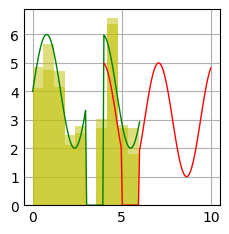

In [4]:
import matplotlib.pyplot as plt
import numpy as np

class RIS:
    y = 0
    w_sum = 0
    M = 0
    W = 0
    def __init__(self) -> None:
        pass
    def update(self, x, w):
        """ update the reservoir
        @param: selected x
        @param: weight (hat_pdf(x) / pdf(x))
        """
        self.w_sum = self.w_sum + w
        self.M = self.M + 1
        if (self.w_sum == 0):
            return 
        r = np.random.uniform(0, 1)
        if r < (w / self.w_sum): 
            self.y = x

plt.style.use('_mpl-gallery')

def is_in_domain(domain, sample):
    return sample <= domain[-1] and sample >= domain[0]

def first_target_pdf(x):
    # return 2 - 2 * x 
    if (x >= 0 and x <= 3) or (x >= 4 and x <= 6):
        return 4 + 2 * np.sin(2 * x)
        # return (x - 1) ** 2 + (x - 1) ** 3 + 1  + (x - 1) ** 2 + (x - 1)

    else:
        return 0
def second_target_pdf(x):
    # return 2 - 2 * x 
    if (x >= 4 and x <= 5) or (x >= 6  and x <= 10):
        return 3 + 2 * np.sin(2 * x)
    else:
        return 0

"""
Version3: partial of the source pdf (reused from neighbour) is zero
"""
fig1, ax1 = plt.subplots()
first_domain = np.linspace(0, 6, 100)
second_domain = np.linspace(4, 10, 100)
first_y = np.zeros(100)
second_y = np.zeros(100)
for i in range(0, len(first_domain)):
    first_y[i] = first_target_pdf(first_domain[i])
for i in range(0, len(first_domain)):
    second_y[i] = second_target_pdf(second_domain[i])
ax1.plot(first_domain, first_y, 'g', linewidth=1)
ax1.plot(second_domain, second_y, 'r', linewidth=1)

#***********************************
#* Regular Monte Carlo integration
#***********************************
sample_size = 1000

value = 0
contributions = []
for i in range(0,sample_size):
    y = np.random.uniform(0, 6.0)
    pdf = 1.0 / 6.0
    c = first_target_pdf(y) / pdf
    value += c
    contributions.append(c)
print("Domain 1 integral: ", value / sample_size, " std: ", np.std(contributions))

value = 0
for i in range(0,sample_size):
    y = np.random.uniform(4, 10)
    pdf = 1.0 / 6.0
    c = second_target_pdf(y) / pdf
    value += c
    contributions.append(c)
print("Domain 2 integral: ", value / sample_size, " std: ", np.std(contributions))

def first_source_pdf(x):
    if x >= 0 and x < 6:
        return 1/6.0
    return 0

def second_source_pdf(x):
    if x >= 4 and x < 10:
        return 1/6.0
    return 0


# mis
sample_size = 1000
ws_naive = np.zeros(sample_size)
ws_mis = np.zeros(sample_size)
ws_bias = np.zeros(sample_size)
ys_naive = np.zeros(sample_size)
ys_mis = np.zeros(sample_size)
ys_bias = np.zeros(sample_size)

ws1 = np.zeros(sample_size)
ys1 = np.zeros(sample_size)
ws2 = np.zeros(sample_size)
ys2 = np.zeros(sample_size)
M = 32
value = 0
value1 = 0
value2  = 0
contribute = []
contribute1 = []
contribute2 = []

for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = first_target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    if (first_target_pdf(reservoir1.y) == 0):
        reservoir1.W = 0
    else:
        reservoir1.W = 1 / first_target_pdf(reservoir1.y) * (1 / reservoir1.M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 
    value1 += first_target_pdf(reservoir1.y) * ws1[idx]
    contribute1.append(ys1[idx])

    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed
        w = second_target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    if (second_target_pdf(reservoir2.y) == 0):
        reservoir2.W = 0
    else:
        reservoir2.W = 1 / second_target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 
    value2 += second_target_pdf(reservoir2.y) * ws2[idx]
    contribute2.append(ys2[idx])

    reservoirs = [reservoir1, reservoir2]
    target_pdfs = [first_target_pdf, second_target_pdf]
    reservoir = RIS()
    # for i in range (0, len(reservoirs)):
    #     r = reservoirs[i]
    #     p_sum = 0
    #     for j in range (0, len(reservoirs)):
    #         p_sum += target_pdfs[j](r.y)
    #     m = target_pdfs[i](r.y) / p_sum * len(reservoirs)
    #     reservoir.update(r.y, first_target_pdf(r.y) * r.M * r.W * m)
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        if r.W == 0:
            continue
        # reservoir.update(r.y, first_target_pdf(r.y) * r.W * r.M)
        reservoir.update(r.y, first_target_pdf(r.y) * r.W)


    reservoir.M = 0
    for i in range (0, len(reservoirs)):
        reservoir.M +=  reservoirs[i].M 
    
    p_sum = 0
    # Z = 0
    for i in range (0, len(reservoirs)):
        if i == 0 and is_in_domain(first_domain, reservoir.y) and target_pdfs[0](reservoir.y) > 0:
            p_sum += target_pdfs[i](reservoir.y) 
            # Z +=  reservoirs[i].M 
        if i == 1 and is_in_domain(second_domain, reservoir.y) and target_pdfs[1](reservoir.y) > 0:
            p_sum += target_pdfs[i](reservoir.y)
            # Z +=  reservoirs[i].M 

   
    if reservoir.y == reservoir1.y:
        contri = target_pdfs[0](reservoir.y) 
        # contri = 1/reservoir.M

    else:
        contri = target_pdfs[1](reservoir.y) 
        # contri = reservoir2.M

    m = contri / p_sum
    # m = 1.0 / Z
    ys_mis[idx] = reservoir.y 
    ws_mis[idx] = 1 / first_target_pdf(reservoir.y) * m * reservoir.w_sum 
    value += first_target_pdf(reservoir.y) * ws_mis[idx]
    contribute.append(ys_mis[idx])
    # if (1/ws_mis[idx]) < 1.5:
    #     print("notice", reservoir.y, 1 / ws_mis[idx], first_target_pdf(reservoir.y), m, reservoir.w_sum, flag)
    #     print(reservoir1.y, reservoir1.W, reservoir2.y, reservoir2.W)
    # ws_bias[idx] = 1 / first_target_pdf(reservoir.y) * (1 / reservoir.M) * reservoir.w_sum

counts,bins = np.histogram(ys_mis, bins=512, density=True)
# plt.hist(bins[:-1], weights=counts, alpha=0.5, color="r")
print("=========================== mis ============================")
print("Domain 1 estimated value: ", value1/sample_size, " std: ", np.std(contribute1))
print("Domain 2 estimated value: ", value2/sample_size, " std: ", np.std(contribute2))
print(value/sample_size, "std", np.std(contribute))


#====================== naive ==================

value = 0
value1 = 0
value2 = 0
contribute_naive = []
contribute1 = []
contribute2 = []

for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = first_target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    reservoir1.W = 1 / first_target_pdf(reservoir1.y) * (1 / reservoir1.M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 

    value1 += first_target_pdf(reservoir1.y) * ws1[idx]
    contribute1.append(reservoir1.y)

    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed

        w = second_target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    reservoir2.W = 1 / second_target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 

    value2 += second_target_pdf(reservoir2.y) * ws2[idx]
    contribute2.append(reservoir2.y)

    reservoirs = [reservoir1, reservoir2]
    reservoir = RIS()
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        reservoir.update(r.y, first_target_pdf(r.y) * r.M * r.W)
 
    
    pq1 = first_target_pdf(reservoir.y)
    pq2 = second_target_pdf(reservoir.y)

   
    
    Z = 0
    if pq1 > 0 and is_in_domain(first_domain, reservoir.y):
        Z += reservoir1.M
    if pq2 > 0 and is_in_domain(second_domain, reservoir.y):
        Z += reservoir2.M 
        
    ys_naive[idx] = reservoir.y
    ws_naive[idx] = 1 / first_target_pdf(reservoir.y) * (1 / Z) * reservoir.w_sum

    value += first_target_pdf(reservoir.y) * ws_naive[idx]
    contribute_naive.append(reservoir.y)

counts,bins = np.histogram(ys_naive, bins=200, density=True)
plt.hist(bins[:-1], weights=counts, alpha=0.5, color="y")
# ax1.scatter(ys_naive, 1 / ws_naive, s = 0.5, c = 'y')
print("=========================== naive ============================")

print("Domain 1 estimated value: ", value1/sample_size, " std: ", np.std(contribute1))
print("Domain 2 estimated value: ", value2/sample_size, " std: ", np.std(contribute2))
print(value/sample_size, " std: ", np.std(contribute_naive))


# bias
for idx in range(0, sample_size):
    reservoir1 = RIS()
    for i in range(0, M):
        x = np.random.uniform(0, 6) # uniform distributed
        w = first_target_pdf(x) / first_source_pdf(x)
        reservoir1.update(x, w)
    reservoir1.W = 1 / first_target_pdf(reservoir1.y) * (1 / reservoir1.M) * reservoir1.w_sum
    ws1[idx] = reservoir1.W 
    ys1[idx] = reservoir1.y 

    value1 += first_target_pdf(reservoir1.y) * ws1[idx]
    contribute1.append(reservoir1.y)

    reservoir2 = RIS()
    for i in range(0, M):
        x = np.random.uniform(4, 10) # uniform distributed

        w = second_target_pdf(x) / second_source_pdf(x)
        reservoir2.update(x, w)
    reservoir2.W = 1 / second_target_pdf(reservoir2.y) * (1 / reservoir2.M) * reservoir2.w_sum
    ws2[idx] = reservoir2.W 
    ys2[idx] = reservoir2.y 

    value2 += second_target_pdf(reservoir2.y) * ws2[idx]
    contribute2.append(reservoir2.y)

    reservoirs = [reservoir1, reservoir2]
    reservoir = RIS()
    for i in range (0, len(reservoirs)):
        r = reservoirs[i]
        reservoir.update(r.y, first_target_pdf(r.y) * r.M * r.W)
 
    ys_naive[idx] = reservoir.y
    ws_naive[idx] = 1 / first_target_pdf(reservoir.y) * (1 / M) * reservoir.w_sum

    value += first_target_pdf(reservoir.y) * ws_naive[idx]
    contribute_naive.append(reservoir.y)

counts,bins = np.histogram(ys_naive, bins=200, density=True)
plt.hist(bins[:-1], weights=counts, alpha=0.5, color="y")
# ax1.scatter(ys_naive, 1 / ws_naive, s = 0.5, c = 'y')
print("=========================== bias ============================")

print("Domain 1 estimated value: ", value1/sample_size, " std: ", np.std(contribute1))
print("Domain 2 estimated value: ", value2/sample_size, " std: ", np.std(contribute2))
print(value/sample_size, " (Expected", 21 + np.cos(8) - np.cos(6) - np.cos(12), ")")

plt.show()
